<a href="https://colab.research.google.com/github/coder-penguin/ML/blob/master/tutorial/keras_tutorial_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sample code for binary classification with RNN

Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, BatchNormalization, Activation, Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import SVG

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


2.2.0-rc2


In [2]:
#check GPU
tf.test.gpu_device_name()

'/device:GPU:0'

Read data

In [0]:
# read the imdb dataset
max_features = 20000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

In [4]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

25000 25000
25000 25000


In [0]:
#load word to index dictionary
word_index = imdb.get_word_index()

In [6]:
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [0]:
#create a dictionary of index to word
index_word = dict([(value, key) for (key, value) in word_index.items()])

In [8]:
index_word

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [9]:
len(X_train[0])

218

In [0]:
decoded_review = ' '.join([index_word.get(i - 3, '?') for i in X_train[0]])

In [11]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what t

In [0]:
#pad sequences with 0 or shrink
maxlen = 180
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [13]:
len(X_train[0])

180

In [14]:
#positive or negative review
y_train

array([1, 0, 0, ..., 0, 1, 0])

###Train model

In [0]:
def build_model(RNNtype):
  activation = 'tanh'
  h_nodes = 20
  if RNNtype == 'Simple':
    RNNcell = SimpleRNN(h_nodes, activation=activation)
  elif RNNtype == 'LSTM':
    RNNcell = LSTM(h_nodes, activation=activation)
  elif RNNtype == 'GRU':
    RNNcell = GRU(h_nodes, activation=activation)

  model = Sequential([
    Embedding(input_dim=max_features, output_dim=100, input_length=maxlen, embeddings_initializer='glorot_uniform'),
    RNNcell,
    Dense(1, activation='sigmoid')
  ], name='model_'+RNNtype)

  #compile
  loss = 'binary_crossentropy'
  optimizer = SGD(lr=0.1, nesterov=True)
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  return model

In [0]:
models = {'Simple' : build_model('Simple'),
                'LSTM' : build_model('LSTM'),
                'GRU' : build_model('GRU')}

In [17]:
for key in models:
  models[key].summary()

Model: "model_Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 100)          2000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20)                2420      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 2,002,441
Trainable params: 2,002,441
Non-trainable params: 0
_________________________________________________________________
Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 100)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 20)                9680      
________________________

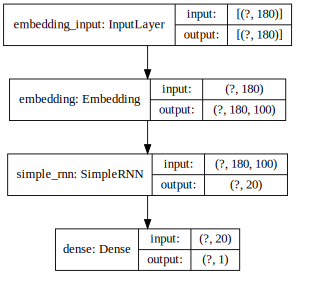

In [18]:
SVG(model_to_dot(models['Simple'], show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [19]:
!mkdir log

mkdir: cannot create directory ‘log’: File exists


In [0]:
callbacks = [#EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), #stop training if there is no improvement
                   ModelCheckpoint('./log/model_{epoch:03d}_{val_loss:.4f}.h5', save_best_only=True) #save models
                   ]

In [21]:
histories = dict()
for key in models:
  histories[key] = models[key].fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
98/98 [==============================] - 20s 204ms/step - loss: 0.6888 - accuracy: 0.5353 - val_loss: 0.6822 - val_accuracy: 0.5798
Epoch 2/100
98/98 [==============================] - 20s 202ms/step - loss: 0.6730 - accuracy: 0.5932 - val_loss: 0.6702 - val_accuracy: 0.5885
Epoch 3/100
98/98 [==============================] - 20s 202ms/step - loss: 0.6581 - accuracy: 0.6140 - val_loss: 0.6617 - val_accuracy: 0.5996
Epoch 4/100
98/98 [==============================] - 20s 200ms/step - loss: 0.6401 - accuracy: 0.6357 - val_loss: 0.6438 - val_accuracy: 0.6232
Epoch 5/100
98/98 [==============================] - 20s 205ms/step - loss: 0.6234 - accuracy: 0.6603 - val_loss: 0.6248 - val_accuracy: 0.6406
Epoch 6/100
98/98 [==============================] - 19s 198ms/step - loss: 0.5987 - accuracy: 0.6771 - val_loss: 0.6186 - val_accuracy: 0.6551
Epoch 7/100
98/98 [==============================] - 20s 203ms/step - loss: 0.6352 - accuracy: 0.6235 - val_loss: 0.6927 - val_accuracy:

In [0]:
def plot_loss_and_accuracy(history):
  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(history.epoch, history.history["accuracy"], label="train_accuracy")
  plt.plot(history.epoch, history.history["val_accuracy"], label="val_accuracy")
  plt.xlabel("epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(history.epoch, history.history["loss"], label="train_loss")
  plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
  plt.xlabel("epoch")
  plt.legend()

Simple
LSTM
GRU


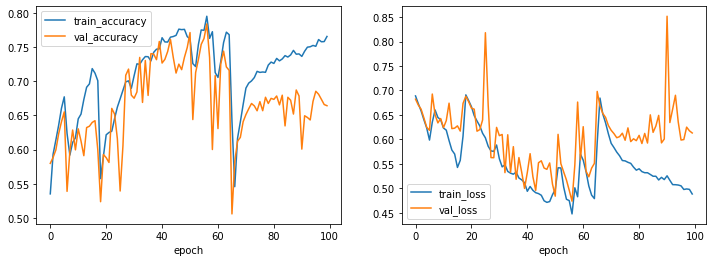

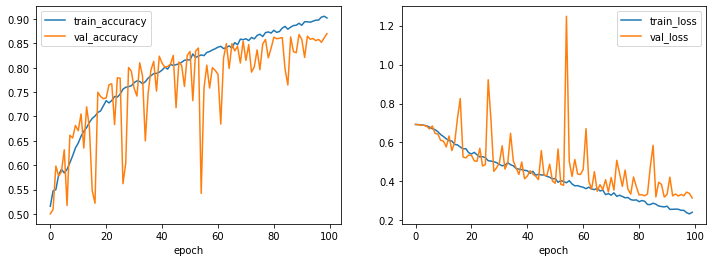

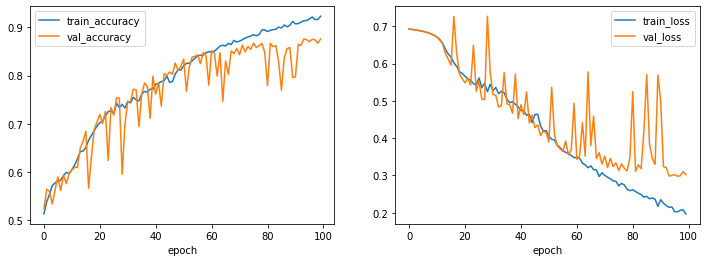

In [23]:
for key in histories:
  print(key)
  plot_loss_and_accuracy(histories[key])

###Evaluation

k-th cross validation

In [0]:
def cross_validation(X, y, cv=None, epochs=100, batch_size=256):
  kf = KFold(n_splits=cv, shuffle=True)

  y_probas = [0] * len(y)
  accuracy_list = []
  for train_index, val_index in kf.split(X, y):
    train_data = X[train_index]
    train_label = y[train_index]
    val_data = X[val_index]
    val_label = y[val_index]

    model = build_model('GRU')
    history = model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_label))
    val_probas = model.predict(val_data)
    for i, index in enumerate(val_index):
      y_probas[index] = val_probas[i][0]

    plot_loss_and_accuracy(history)

    accuracy = np.max(history.history['val_accuracy'])
    print('accuracy : ', accuracy)
    accuracy_list.append(accuracy)

  print('accuracy : ', np.mean(accuracy_list), ' +- ', np.std(accuracy_list))  

  return y_probas

Epoch 1/100
66/66 [==============================] - 2s 34ms/step - loss: 0.6929 - accuracy: 0.5117 - val_loss: 0.6927 - val_accuracy: 0.4976
Epoch 2/100
66/66 [==============================] - 2s 29ms/step - loss: 0.6922 - accuracy: 0.5263 - val_loss: 0.6918 - val_accuracy: 0.5138
Epoch 3/100
66/66 [==============================] - 2s 30ms/step - loss: 0.6915 - accuracy: 0.5375 - val_loss: 0.6917 - val_accuracy: 0.5086
Epoch 4/100
66/66 [==============================] - 2s 32ms/step - loss: 0.6908 - accuracy: 0.5556 - val_loss: 0.6909 - val_accuracy: 0.5208
Epoch 5/100
66/66 [==============================] - 2s 30ms/step - loss: 0.6900 - accuracy: 0.5578 - val_loss: 0.6899 - val_accuracy: 0.5804
Epoch 6/100
66/66 [==============================] - 2s 29ms/step - loss: 0.6892 - accuracy: 0.5871 - val_loss: 0.6892 - val_accuracy: 0.5535
Epoch 7/100
66/66 [==============================] - 2s 29ms/step - loss: 0.6883 - accuracy: 0.5831 - val_loss: 0.6887 - val_accuracy: 0.5370
Epoch 

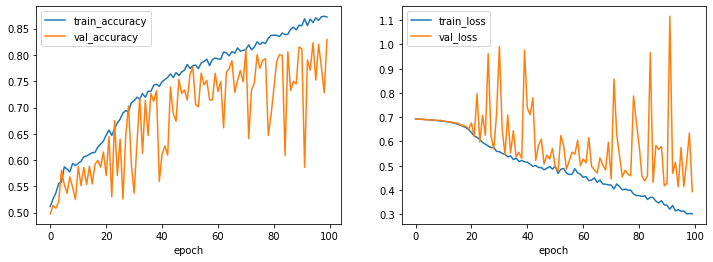

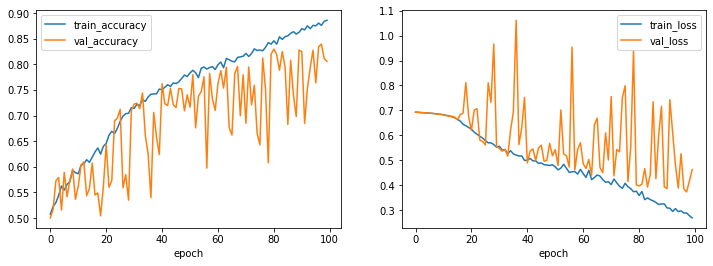

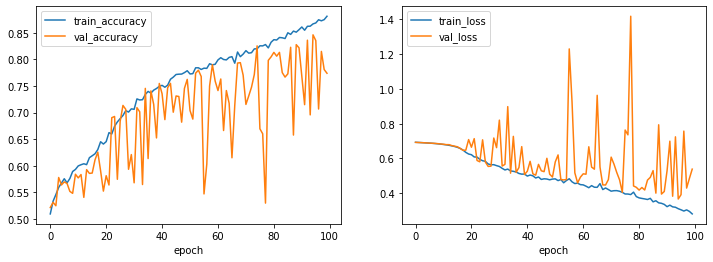

In [25]:
#k-th cross validation
cv = 3 #the number of foldings
y_train_probas = cross_validation(X_train, y_train, cv=cv)

In [0]:
y_train_one = []
y_train_zero = []
for i, x in enumerate(y_train_probas):
  if y_train[i] == 1:
    y_train_one.append(x)
  else :
    y_train_zero.append(x)

(array([1885., 1397.,  883.,  621.,  480.,  402.,  324.,  266.,  258.,
         231.,  193.,  181.,  192.,  138.,  132.,  135.,  117.,  140.,
         155.,  128.,  126.,  137.,  110.,   94.,  103.,  111.,  120.,
         112.,  106.,  100.,  106.,  118.,   96.,  123.,  119.,  116.,
         121.,  111.,  134.,  138.,  136.,  134.,  142.,  141.,  173.,
         191.,  217.,  284.,  288.,  235.]),
 array([0.00101441, 0.02093219, 0.04084997, 0.06076775, 0.08068553,
        0.10060332, 0.1205211 , 0.14043888, 0.16035666, 0.18027444,
        0.20019223, 0.22011   , 0.24002779, 0.25994557, 0.27986336,
        0.29978114, 0.3196989 , 0.3396167 , 0.35953447, 0.37945226,
        0.39937004, 0.41928783, 0.4392056 , 0.45912337, 0.47904116,
        0.49895895, 0.51887673, 0.5387945 , 0.5587123 , 0.5786301 ,
        0.5985479 , 0.61846566, 0.6383834 , 0.6583012 , 0.67821896,
        0.69813675, 0.71805453, 0.7379723 , 0.7578901 , 0.7778079 ,
        0.7977257 , 0.81764346, 0.83756125, 0.85747904, 

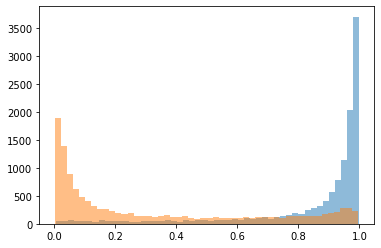

In [27]:
plt.hist(y_train_one, bins=50, alpha=0.5)
plt.hist(y_train_zero, bins=50, alpha=0.5)

confusion matrix

In [0]:
#calculate confusion matrix
#y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
threshold = 0.5
y_train_pred = [y_train_probas[i]>threshold for i in range(len(y_train_probas))]
conf_mx = confusion_matrix(y_train, y_train_pred)

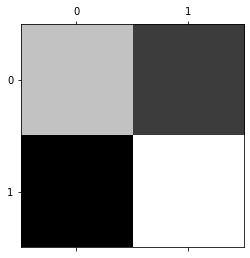

In [29]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

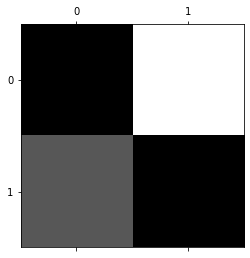

In [30]:
#convert to error probability
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#set diagonal to 0 for visibility
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

various scores

In [31]:
accuracy_score(y_train, y_train_pred)

0.80308

In [32]:
precision_score(y_train, y_train_pred)

0.7541423492319045

In [33]:
recall_score(y_train, y_train_pred)

0.89936

In [34]:
f1_score(y_train, y_train_pred)

0.8203743569161163

In [35]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.71      0.78     12500
           1       0.75      0.90      0.82     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



In [0]:
y_train_scores = y_train_probas

In [0]:
def plot_pr_curve(y, y_score, label=None):

    fpr, tpr, thresholds = precision_recall_curve(y, y_score)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [1, 0], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    return

No handles with labels found to put in legend.


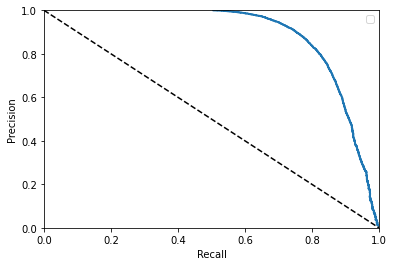

In [38]:
plot_pr_curve(y_train, y_train_scores)
plt.show()

In [0]:
def plot_roc_curve(y, y_score, label=None):

    fpr, tpr, thresholds = roc_curve(y, y_score)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    return

No handles with labels found to put in legend.


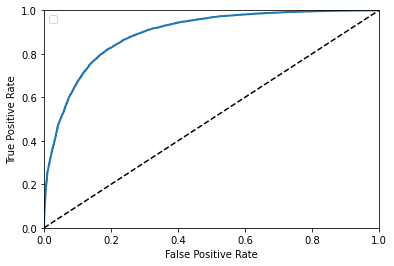

In [40]:
plot_roc_curve(y_train, y_train_scores)
plt.show()

In [41]:
roc_auc_score(y_train, y_train_scores)

0.8935915039999999

###Test

In [48]:
model = models['GRU']
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)

196/196 [==============================] - 2s 8ms/step - loss: 0.3023 - accuracy: 0.8761


In [49]:
print('test loss : ', test_loss, ', accuracy : ', test_accuracy)

test loss :  0.30232053995132446 , accuracy :  0.8760799765586853


In [0]:
y_test_probas = model.predict(X_test)

In [0]:
threshold = 0.5
y_test_pred = [int(x[0]>threshold) for x in y_test_probas]

In [53]:
print(y_test_pred)

[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 

###Save

In [0]:
#save the prediction
submissiondir = '.'
submissionname = 'submission'
pd.DataFrame(data={'target':y_test, 'prediction':y_test_pred}).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=["Id"])

In [0]:
# save the model
filename = 'model.h5'
model.save(filename)

In [58]:
# load the model
loaded_model = load_model(filename)
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test, batch_size=128)

196/196 [==============================] - 2s 8ms/step - loss: 0.3023 - accuracy: 0.8761


In [59]:
print('test loss : ', test_loss, ', accuracy : ', test_accuracy)

test loss :  0.30232053995132446 , accuracy :  0.8760799765586853
